### 1.  Libraries Import

In [60]:
import yfinance as yf    ## yahoo finance for stock data
import numpy as np      
import pandas as pd
import seaborn as sns    ## for Vizualization
import matplotlib.pyplot as plt           ## for Vizualization
from sklearn.preprocessing import MinMaxScaler   ## For scaling the data
from sklearn.metrics import mean_absolute_error,mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout   ## importing layers of Neural network
from keras.callbacks import ModelCheckpoint     ## imporing modelcheck pointer
from keras.losses import MSE                  ## importing error function
from keras.optimizers import Adam              ## importing optimizer
from keras.activations import relu           ## importing activation function
import os

sns.set()

### 2. Loading in Dataset

######    i)   Stock data used TSLA (Tesla)
######   ii)   From 06/29/2010 (i.e. TSLA's IPO Date ) to 06/20/2019
######  iii)   Data is of 24 hr interval

In [119]:
'''
Download the data using yahoo finance or load from downloaded data
'''
try:
    df = pd.read_csv('TSLA_stock_price.csv', index_col = 0)
except:
    df = yf.download('TSLA','2010-06-29','2019-06-21',interval='1d')
    export_csv = df.to_csv ('TSLA_stock_price.csv', index = 'Date', header=True)
# store a copy for model evaluation
df1 = df.copy()

### 3. Preprocessing and Feature Extraction

I will be predicting the opening of TSLA stock 

In [121]:
df = df['Open'].values
print("Total No. of days of TSLA's Stocks :",df.shape[0])

Total No. of days of TSLA's Stocks : 2258


#### Splitting the data into train test split

In [122]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
print('Training stock :',dataset_train.shape[0],'days')
print('Test stock :',dataset_test.shape[0],'days')

Training stock : 1806 days
Test stock : 502 days


#### Scaling the data

a) Train Data

In [123]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train.reshape(-1, 1))

b) Test Data

In [125]:
dataset_test = scaler.transform(dataset_test.reshape(-1, 1))

In [126]:
def create_dataset(df,n):
    '''
    Function to prepare data for the LSTM
    
    '''
    
    x = []
    y = []
  
    for i in range(n, df.shape[0]):
        x.append(df[i-n:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y 

In [127]:
x_train, y_train = create_dataset(dataset_train,50)

In [128]:
x_test, y_test = create_dataset(dataset_test,50)

#### Reshape features for LSTM Layer

In [129]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [130]:
print('Training data shape',x_train.shape)
print('Test data shape',x_test.shape)

Training data shape (1756, 50, 1)
Test data shape (452, 50, 1)


### 4. Building Model

In [131]:
model = Sequential()

model.add(LSTM(units=96, 
               return_sequences=True,
               input_shape=(x_train.shape[1], 1)))

model.add(Dropout(0.2))

model.add(LSTM(units=96, 
               return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(units=96, 
               return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(units=96))

model.add(Dropout(0.2))

model.add(Dense(units=1))

In [133]:
model.compile(loss=MSE, optimizer=Adam())

In [134]:
checkpointer = ModelCheckpoint(filepath='tesla.stock_prediction.hdf5',save_best_only=True,verbose=1)

callbacks = [checkpointer]

In [136]:

history = model.fit(x_train,y_train,batch_size=32,epochs=70,verbose=1,callbacks=[checkpointer],validation_split=0.05)


In [137]:
model = load_model('tesla.stock_prediction.hdf5')

#### Best model saved as 'tesla.stock_prediction.hdf5'

### 5. Visualizing Results

#### Plotting the Predicted Stock Price with True Stock Price

In [140]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

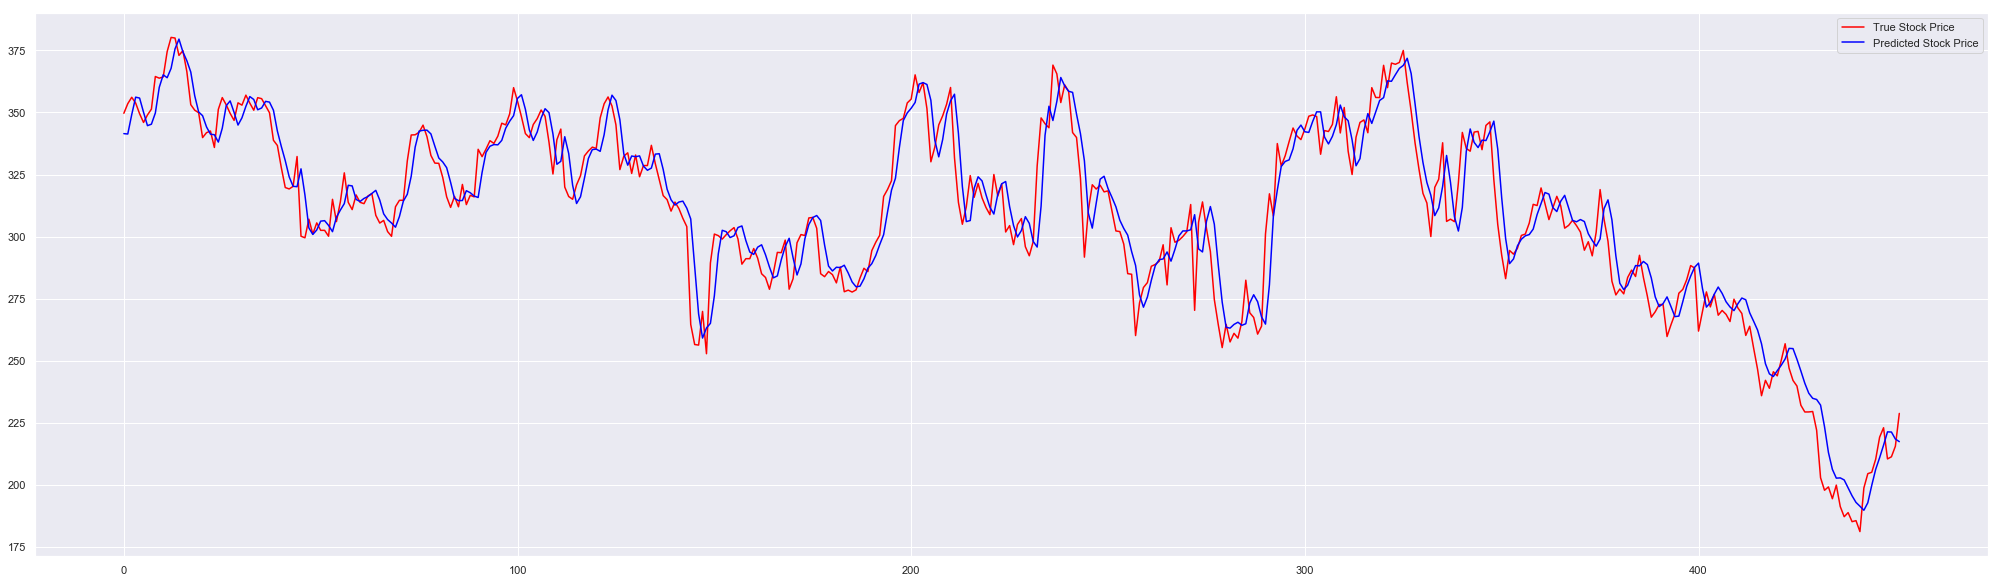

In [141]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


fig, ax = plt.subplots(figsize=(35,10))
ax.plot(y_test_scaled, color='red', label='True Stock Price')
plt.plot(predictions, color='blue', label='Predicted Stock Price')
plt.legend()

The Graph looks beautiful !!

## 6. Evaluation

In [35]:
df1.reset_index(inplace=True)
comparison = df1[['Date','Open']].iloc[len(y_train)+50:] 
comparison['Predictions'] = predictions

In [142]:
print("Mean absolute error of your model is: ",mean_absolute_error(comparison['Open'],comparison['Predictions']))
 

Mean absolute error of your model is:  8.285908018129062
